In [32]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = '/Stanford CS231n/assignments/assignment1'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Stanford CS231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/Stanford CS231n/assignments/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [33]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [35]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.363609
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$

The softmax classifier loss is given by
$$
L_i = -\log \left(\frac{e^{f_{y_i}}}{\sum_j e^{f_j}}\right)
$$
where $f_{j} = w_j^Tx_i$ is the score given to image $x_i$ regarding class $j$ and $f_{y_i} = w_j^Tx_i$, the score given with respect to the correct class, $y_i$.

Here we are initializing the weight matrix randomly: each entry is a random draw from the standard normal distribution $\mathcal{N}(0, 1)$, scaled by a small number $(0.0001)$. This results in all the weights for all the classes and features being quite small and close to zero. As a result, when calculating the softmax function of an image, we will observe similar scores among all the classes, i.e., using these scores is akin to classifying the images at random. Since CIFAR10 has 10 classes, the probability of assigning an image to a class will be around 10%, or 0.1. Therefore, the loss for this weight initialization will be around $-\log(0.1)$.

In [36]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.243192 analytic: 0.243192, relative error: 1.877280e-07
numerical: 1.516501 analytic: 1.516501, relative error: 4.518890e-08
numerical: 0.580036 analytic: 0.580036, relative error: 4.066845e-08
numerical: -0.693460 analytic: -0.693461, relative error: 6.213795e-08
numerical: 0.548077 analytic: 0.548077, relative error: 1.438349e-07
numerical: -4.188844 analytic: -4.188844, relative error: 1.951043e-08
numerical: -0.402100 analytic: -0.402100, relative error: 7.110534e-08
numerical: -2.868129 analytic: -2.868129, relative error: 2.635705e-08
numerical: 4.063905 analytic: 4.063904, relative error: 1.044631e-08
numerical: 1.945015 analytic: 1.945014, relative error: 4.866505e-08
numerical: 3.167429 analytic: 3.167429, relative error: 2.266032e-08
numerical: 1.725537 analytic: 1.725537, relative error: 5.997881e-08
numerical: -4.377517 analytic: -4.377517, relative error: 1.126838e-08
numerical: -1.007076 analytic: -1.007076, relative error: 6.366828e-08
numerical: 3.845408 an

In [53]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.363609e+00 computed in 0.068279s
vectorized loss: 2.363609e+00 computed in 0.006652s
Loss difference: 0.000000
Gradient difference: 0.000000


In [56]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = np.linspace(1e-7, 5e-6, 7)
regularization_strengths = np.linspace(1e3, 5e4, 6)

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        # training
        softmax.train(X_train, y_train, lr, rs, num_iters=1500, verbose=True)
        # evaluation
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        train_accuracy = np.mean(y_train_pred == y_train)
        val_accuracy = np.mean(y_val_pred == y_val)
        results[(lr, rs)] = (train_accuracy, val_accuracy)

        if val_accuracy > best_val:
          best_val = val_accuracy
          best_softmax = softmax


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 36.990417
iteration 100 / 1500: loss 33.798928
iteration 200 / 1500: loss 32.045536
iteration 300 / 1500: loss 30.832600
iteration 400 / 1500: loss 29.096452
iteration 500 / 1500: loss 27.928975
iteration 600 / 1500: loss 26.786712
iteration 700 / 1500: loss 25.846798
iteration 800 / 1500: loss 24.836372
iteration 900 / 1500: loss 23.957444
iteration 1000 / 1500: loss 22.861734
iteration 1100 / 1500: loss 22.014717
iteration 1200 / 1500: loss 21.436121
iteration 1300 / 1500: loss 20.613892
iteration 1400 / 1500: loss 19.738151
iteration 0 / 1500: loss 335.767541
iteration 100 / 1500: loss 217.535514
iteration 200 / 1500: loss 141.327076
iteration 300 / 1500: loss 92.017777
iteration 400 / 1500: loss 60.317480
iteration 500 / 1500: loss 39.806521
iteration 600 / 1500: loss 26.434450
iteration 700 / 1500: loss 17.886344
iteration 800 / 1500: loss 12.270865
iteration 900 / 1500: loss 8.693284
iteration 1000 / 1500: loss 6.280842
iteration 1100 / 1500: loss 4.78334

In [58]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.391000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$

True


$\color{blue}{\textit Your Explanation:}$

Let us recall the loss functions used for the SVM and Softmax classifier for a datapoint $x_i$. The SVM classifier uses the following hinge loss:
$$
L_i = \sum_{j\neq y_i} \max(s_j - s_{y_i} + \Delta, 0),
$$
where $j$ denotes any class label, $y_i$ denotes the true class label, and $s_j$ and $s_{y_i}$ denote the scores assigned to classes $j$ and $y_i$, respectively. $\Delta > 0$ is the classification margin.

Conversely, the Softmax classifier uses the cross entropy loss:
$$
L_i = -\log\left(\frac{e^{s_{y_i}}}{\sum_j e^{s_j}} \right).
$$

In the case of the SVM classifier, a new data point where the score of the true label, $s_{y_i}$, is higher than any of the other scores, $s_j$, by at least the margin $\Delta$ will result in a hinge loss of $0$ because of the $\max$ operator. Therefore, any new point added to the dataset that satisfies this condition will not change the overall loss.

In contrast, every point added to the training of the Softmax classifier will always change the value of the overall loss. The Softmax classifier aims to assign the highest probability to the correct class $y_i$ (i.e. cloase to $1$) while making the probabilities of the other classes be as small as possible (i.e., approaching $0$). However, even for an arbitrarily small score assigned to the incorrect class $s_j$, $e^{s^j}$ will be stricly greater than zero. Thus, any new point will introduce an individual loss in training, which will influence the overall value of the loss.

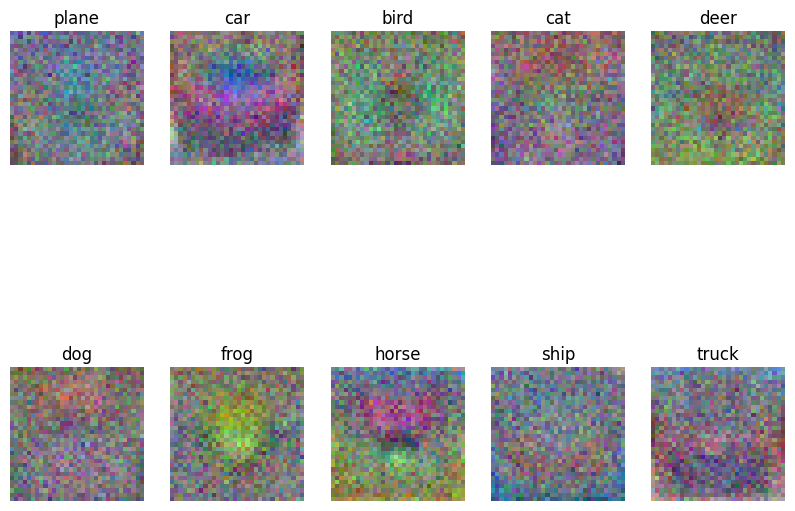

In [59]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])